## About Dataset
*info from https://www.kaggle.com/datasets/putdejudomthai/ecommerce-ab-testing-2022-dataset1* 


*For this project, you will be working to understand the results of an A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. Your goal is to work through this notebook to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.*

In [1]:
# Base
# -----------------------------------
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt


# Hypothesis Testing
# -----------------------------------
from scipy.stats import shapiro, levene, mannwhitneyu


import warnings
warnings.filterwarnings('ignore')

## Importing Data

In [2]:
# Data uploading

data_path = "E:\\Projects\\product m\\pm\\Data Analysis Portfolio\\AB-Test-Portfolio\\ab_data.csv"
df_ab = pd.read_csv(data_path)

print("# MISSING VALUE ---------------------")
print("Are there any missing values? \n ", np.where((df_ab.isnull().values.any() == False) or (df_ab.values.any() == ''), "No missing value!", "Data includes missing value!"), "\n")

# MISSING VALUE ---------------------
Are there any missing values? 
  No missing value! 



In [3]:
data_path = "E:\\Projects\\product m\\pm\\Data Analysis Portfolio\\AB-Test-Portfolio\\countries.csv"
df_countries = pd.read_csv(data_path)

print("# MISSING VALUE ---------------------")
print("Are there any missing values? \n ", np.where(df_countries.isnull().values.any() == False, "No missing value!", "Data includes missing value!"), "\n")

# MISSING VALUE ---------------------
Are there any missing values? 
  No missing value! 



## EDA(Exploratory Data Analysis)

In [4]:
df_ab.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [5]:
df_ab.apply(lambda x: x.nunique())

user_id         290585
timestamp        35993
group                2
landing_page         2
converted            2
dtype: int64

In [6]:
df_ab.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [7]:
df_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
# Remove Duplicates
print(df_ab.shape)
df_ab = df_ab.drop_duplicates(subset='user_id', keep= False)
print(df_ab.shape)

(294480, 5)
(286690, 5)


In [9]:
# Amount of page type entries through groups
df_ab.groupby(['group','landing_page']).agg({'landing_page': lambda x: x.value_counts()})

,,landing_page
group,landing_page,
control,old_page,143293
treatment,new_page,143397


In [10]:
# Mean convertion rate through the landing types
df_ab.groupby(['group','landing_page']).agg({'converted': 'mean'})

,,converted
group,landing_page,
control,old_page,0.120173
treatment,new_page,0.118726


[Text(0, 0, '0.120173'), Text(0, 0, '0.118726')]

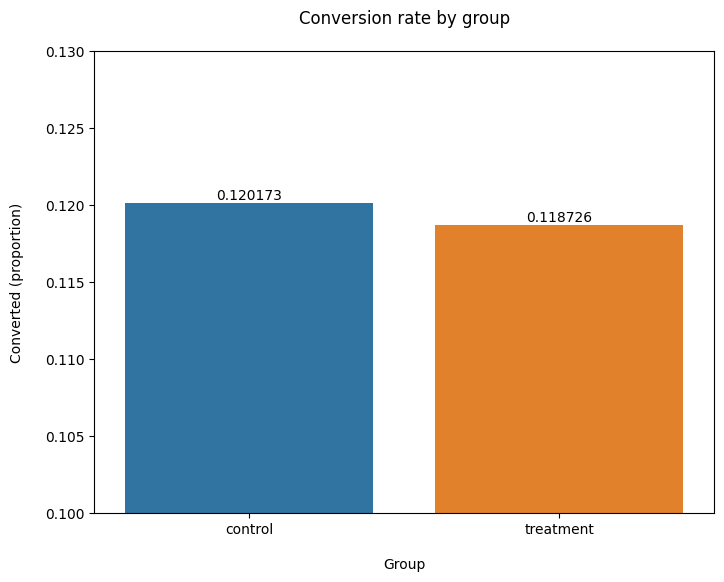

In [11]:
plt.figure(figsize=(8,6))
ax = sns.barplot(x=df_ab['group'], y=df_ab['converted'], errorbar=('ci', False))

plt.ylim(0.10, 0.13)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)
ax.bar_label(ax.containers[0])

In [12]:
# How much percents new and old page occurs in dataset
df_ab['landing_page'].value_counts(normalize=True)*100

new_page    50.018138
old_page    49.981862
Name: landing_page, dtype: float64

In [13]:
# Show all records, where group = control and lp = new_page or records where group = treatment and lp = old_page
df_ab[((df_ab['group'] == 'control') & (df_ab['landing_page'] == 'new_page')) |((df_ab['group'] == 'treatment') & (df_ab['landing_page'] == 'old_page')) ]

,user_id,timestamp,group,landing_page,converted


*There is no such rows so assuming that*


treatment_group = new_page


control_group = old_page

## AB test preparation

### Normality Assumption
- H0: The assumption of normal distribution is provided
- H1: The assumption of normal distribution is not provided


If the p-value is less than 0.05, it is considered significant and a non-parametric test (mannwhitneyu test) will be used. Else a parametric test (t-test)

In [14]:
# Hypothesis set
norm_h0 = "The assumption of normal distribution is provided"
norm_h1 = "The assumption of normal distribution is NOT provided"

In [15]:
# Applying shapiro test to understand is data distributed normally
test_stat, pvalue = shapiro(df_ab.loc[df_ab["landing_page"] == "old_page", "converted"])
print('---------Shapiro test result for OLD PAGE----------')
print("p-value:",pvalue)
print("test_stat:",test_stat)
print(f'pvalue: {pvalue} < 0.05, hypothesis "{norm_h1}" is correct') if pvalue < 0.05 else print(f'pvalue: {pvalue} > 0.05, hypothesis "{norm_h0}" is correct')

print("\n")

test_stat, pvalue = shapiro(df_ab.loc[df_ab["landing_page"] == "new_page", "converted"])
print('---------Shapiro test result for NEW PAGE----------')
print("p-value:",pvalue)
print("test_stat:",test_stat)
print(f'pvalue: {pvalue} < 0.05, accepting hypothesis "{norm_h1}"') if pvalue < 0.05 else print(f'pvalue: {pvalue} > 0.05, accepting hypothesis "{norm_h0}"')

---------Shapiro test result for OLD PAGE----------
p-value: 0.0
test_stat: 0.3792334198951721
pvalue: 0.0 < 0.05, hypothesis "The assumption of normal distribution is NOT provided" is correct


---------Shapiro test result for NEW PAGE----------
p-value: 0.0
test_stat: 0.37685757875442505
pvalue: 0.0 < 0.05, accepting hypothesis "The assumption of normal distribution is NOT provided"


- Because norm distribution is not provied we will use non-parametric test(mannwhitneyu test)

#### Variance Homogeneity

- H0: Variances are homogeneous
- H1: Variances are not homogeneous

In [16]:
# Hypothesis set
homogen_h0 = "Variances are homogeneous"
homogen_h1 = "Variances are NOT homogeneous"

In [17]:
# Applying levene test for data homogeneity test
test_stat, pvalue = levene(df_ab.loc[df_ab["landing_page"] == "new_page", "converted"],
                           df_ab.loc[df_ab["landing_page"] == "old_page", "converted"])
print("p-value:",pvalue)  
print("test_stat:",test_stat)
print(f'pvalue: {pvalue} < 0.05, accepting hypothesis: {homogen_h1}') if pvalue < 0.05 else print(f'pvalue: {pvalue} > 0.05, accepting hypothesis: "{homogen_h0}"')

p-value: 0.2322897281547632
test_stat: 1.4267917566652295
pvalue: 0.2322897281547632 > 0.05, accepting hypothesis: "Variances are homogeneous"


### Hypothesis testing

A non-parametric test with mannwhitneyu test

- H0: There is not statistically significant difference between the old page and new page

- H1: There is statistically significant difference between the old page and new page


**Let's use a mannwhitney-U criterion to determine whether a nominal two-level factor (in our case the type of page) affects the quantitative response (conversion)**

In [18]:
# Hypothesis set
testing_h0 = "There is no statistically significant difference between the old page and new page convertion"
testing_h1 = "There is statistically significant difference between the old page and new page convertion"

In [19]:
test_stat, pvalue = mannwhitneyu(df_ab.loc[df_ab["landing_page"] == "new_page", "converted"],
                                 df_ab.loc[df_ab["landing_page"] == "old_page", "converted"])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))
test_stat, pvalue = levene(df_ab.loc[df_ab["landing_page"] == "new_page", "converted"],
                           df_ab.loc[df_ab["landing_page"] == "old_page", "converted"])
print("p-value:",pvalue)  
print("test_stat:",test_stat)
print(f'pvalue: {pvalue} < 0.05, accepting hypothesis: {testing_h1}') if pvalue < 0.05 else print(f'pvalue: {pvalue} > 0.05, accepting hypothesis: "{testing_h0}"')

Test Stat = 10259026653.0000, p-value = 0.2323
p-value: 0.2322897281547632
test_stat: 1.4267917566652295
pvalue: 0.2322897281547632 > 0.05, accepting hypothesis: "There is no statistically significant difference between the old page and new page convertion"


**As we can see from the analysis, we can not reject the null hypothesis, which means that the use of a new landing page for users has no effect on the conversion rate.**

**From this we can move on to the analysis at the product context level.**

## Additional exploration for insights (Geographical)
Let's look throught geographically located userbase and find out usefull insights

In [20]:
# Consolidate datasets
df_cons = pd.merge(df_ab, df_countries, on='user_id')
df_cons.head()

,user_id,timestamp,group,landing_page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
4,864975,52:26.2,control,old_page,1,US


In [28]:
# Convertion rate changing from NEW to OLD page groups 
df_cntr_new = df_cons[df_cons['landing_page'] == 'new_page'].groupby(['country'], as_index = False)['converted'].mean()
df_cntr_old = df_cons[df_cons['landing_page'] == 'old_page'].groupby(['country'], as_index = False)['converted'].mean()
df_substracted = df_cntr_old.set_index('country').subtract(df_cntr_new.set_index('country'),fill_value = 0)
df_substracted['converted'] = df_substracted['converted'].apply(lambda x: round((x * 100),3))
df_substracted.columns = df_substracted.columns.str.replace('converted', 'Old page conv. - New page conv.')

df_substracted

,Old page conv. - New page conv.
country,
CA,0.661
UK,-0.147
US,0.211


In [22]:
# Preparing df for hue plotting 
df_cntr_new['group'] = 'new page'
df_cntr_old['group'] = 'old page'

# Creating concatenated df 
df_cntr_group = df_cntr_new.append(df_cntr_old, ignore_index = True)

# Rounding convertion rates
df_cntr_group['converted'] = df_cntr_group['converted'].apply(lambda x: round((x * 100),3))

# Group consolidated df by country
df_countr_group = df_cons.groupby('country', as_index=True).mean()[['converted']]

Text(0.5, 1.0, 'Convertion rates through page types for countries')

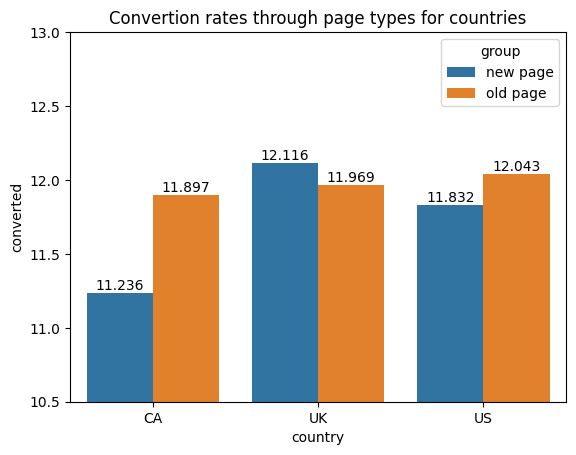

In [23]:
ax = sns.barplot(data=df_cntr_group, x="country", y="converted", hue="group")
for i in ax.containers:
    ax.bar_label(i,)

ax.set_ylim(10.5,13)
ax.set_title('Convertion rates through page types for countries')